In [1]:
import os 
import json
from datetime import datetime

import math
import numpy as np

from utils.input import setup, exercise_to_input

# Setttings

In [2]:
data_set = 'exercises_raw_heathy'
#exercises_raw
#exercises_raw_heathy

In [3]:
SEQ_MAX_LEN = 600
NUM_CLASSES = 6
NUM_EXERCISES = 9
NUM_FLAG_BS = 2

In [4]:
dir_root = os.path.join('..')
dir_data_root = os.path.join(dir_root, 'data')
dir_exercises = os.path.join(dir_data_root, 'json', data_set)

In [5]:
CONFIG = setup(os.path.join('..'), SEQ_MAX_LEN, NUM_EXERCISES, NUM_FLAG_BS)

In [6]:
CONFIG

{'ROOT_PATH': '..',
 'ALL_REGIONS': ['frontal', 'orbital', 'oral'],
 'REGIONS': {'0_LefteyeMidbottom': 'orbital',
  '1_LefteyeMidtop': 'orbital',
  '2_LefteyeInnercorner': 'orbital',
  '3_LefteyeOutercorner': 'orbital',
  '4_LefteyebrowInner': 'frontal',
  '5_LefteyebrowCenter': 'frontal',
  '6_RighteyeMidbottom': 'orbital',
  '7_RighteyeMidtop': 'orbital',
  '8_RighteyeInnercorner': 'orbital',
  '9_RighteyeOutercorner': 'orbital',
  '10_RighteyebrowInner': 'frontal',
  '11_RighteyebrowCenter': 'frontal',
  '12_NoseTip': 'frontal',
  '13_MouthLowerlipMidbottom': 'oral',
  '14_MouthLeftcorner': 'oral',
  '15_MouthRightcorner': 'oral',
  '16_MouthUpperlipMidtop': 'oral',
  '17_ChinCenter': 'oral',
  '18_ForeheadCenter': 'frontal',
  '19_LeftcheekCenter': 'oral',
  '20_RightcheekCenter': 'oral'},
 'BASES': {'0_LefteyeMidbottom': '18_ForeheadCenter',
  '1_LefteyeMidtop': '18_ForeheadCenter',
  '2_LefteyeInnercorner': '18_ForeheadCenter',
  '3_LefteyeOutercorner': '18_ForeheadCenter',
  '4_

# Load all the sessions

In [7]:
def get_patient_id(file):
    if data_set == 'exercises_raw_heathy':
        return file.split('_')[0][7:]
    if data_set == 'exercises_raw':
        return file.split('_')[0].lstrip("0")

    print('!WARNING: Unknown data set')
    return ''

In [8]:
def get_session_id(file):
    if data_set == 'exercises_raw_heathy':
        return file.split('_')[0][7:]
    if data_set == 'exercises_raw':
        return file.split('_')[1]

    print('!WARNING: Unknown data set')
    return ''

load all the sessions to a dictionary

In [9]:
patients_sessions = {}

for file_name in os.listdir(dir_exercises):
    if file_name == '.DS_Store': continue
    
    exercise = json.load(open(os.path.join(dir_exercises, file_name), 'r'))
    
    patient_id = get_patient_id(file_name)
    session_id = get_session_id(file_name)
    exercise_id = exercise['meta']['id']
    
    if patient_id not in patients_sessions:
        patients_sessions[patient_id] = {}
        
    if session_id not in patients_sessions[patient_id]:
        patients_sessions[patient_id][session_id] = {}
        
    data = []
    
    for poi in sorted(CONFIG['REGIONS'].keys()):
        if poi not in exercise['pois']:
            print(f'!WARNING: {poi} is not present in {file_name}')
            continue
            
        data.append({
            'xs': exercise['pois'][poi]['xs'],
            'ys': exercise['pois'][poi]['ys'],
            'zs': exercise['pois'][poi]['zs']
        })
        
    patients_sessions[patient_id][session_id][exercise_id] = data    

# Observations

In [10]:
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

In [11]:
def patient_amount(data):
    return len(data)

In [12]:
def sessions_amount(data):
    sessions = 0
    for patient_id in data:
        sessions += len(data[patient_id])
    
    return sessions

In [13]:
print(f'Overal number of patients:{patient_amount(patients_sessions)}')

Overal number of patients:82


In [14]:
print(f'Overal number of sessions:{sessions_amount(patients_sessions)}')

Overal number of sessions:82


## Exercises length distribution

In [15]:
def get_sessions_lengts(data):
    lengths = []
    for patient_id in data:
        for session_id in data[patient_id]:
            for exercise_id in data[patient_id][session_id]:
                lengths.append(len(data[patient_id][session_id][exercise_id][0]['xs']))
    return lengths

Number of exercises: 719


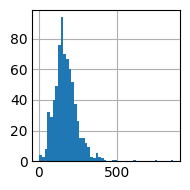

In [19]:
dist = get_sessions_lengts(patients_sessions)

print(f'Number of exercises: {len(dist)}')

fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.hist(dist, bins=50)
plt.show()

In [20]:
def show_problematic_exercises(data, lower_limit=100):
    lengths = []
    for patient_id in data:
        for session_id in data[patient_id]:
            for exercise_id in data[patient_id][session_id]:
                if len(data[patient_id][session_id][exercise_id][0]['xs']) < lower_limit:
                    print(f'Short exercise: Patient {patient_id} Session {session_id} Exercise {exercise_id}')

In [21]:
show_problematic_exercises(patients_sessions, lower_limit = 50)

Short exercise: Patient 2 Session 2 Exercise 1
Short exercise: Patient 320 Session 320 Exercise 3
Short exercise: Patient 119 Session 119 Exercise 1
Short exercise: Patient 119 Session 119 Exercise 2
Short exercise: Patient 308 Session 308 Exercise 6
Short exercise: Patient 168 Session 168 Exercise 7
Short exercise: Patient 168 Session 168 Exercise 4
Short exercise: Patient 168 Session 168 Exercise 3
Short exercise: Patient 104 Session 104 Exercise 2
Short exercise: Patient 104 Session 104 Exercise 5
